In [9]:
import torch
import random
import numpy as np
from PIL import Image, ImageDraw

import matplotlib.pyplot as plt

In [10]:
class BaseTransform:
    def __init__(self, p):
        if not 0.0 <= p <= 1.0:
            raise ValueError("Probability p must be between 0.0 and 1.0")
        self.p = p

    def __call__(self, image):
        if random.random() < self.p:
            return self.apply_transform(image)
        return image

    def apply_transform(self, image):
        raise NotImplementedError

In [11]:
class RandomCrop(BaseTransform):
    def __init__(self, p, **kwargs):
        super().__init__(p)
        self.height = kwargs.get('height')
        self.width = kwargs.get('width')
        if self.height is None or self.width is None:
            raise ValueError("RandomCrop requires 'height' and 'width' in kwargs")

    def apply_transform(self, image):
        img_width, img_height = image.size
        
        if self.width > img_width or self.height > img_height:
            return image

        left = random.randint(0, img_width - self.width)
        top = random.randint(0, img_height - self.height)
        right = left + self.width
        bottom = top + self.height
        
        return image.crop((left, top, right, bottom))

In [12]:
class RandomRotate(BaseTransform):
    def __init__(self, p, **kwargs):
        super().__init__(p)
        self.degrees = kwargs.get('degrees', 0)
        if isinstance(self.degrees, (int, float)):
            self.degrees = (-self.degrees, self.degrees)

    def apply_transform(self, image):
        angle = random.uniform(self.degrees[0], self.degrees[1])
        return image.rotate(angle, resample=Image.Resampling.BILINEAR, expand=True)

In [13]:
class RandomZoom(BaseTransform):
    def __init__(self, p, **kwargs):
        super().__init__(p)
        self.zoom_range = kwargs.get('zoom_range', (1.0, 1.0))
        if not isinstance(self.zoom_range, (list, tuple)) or len(self.zoom_range) != 2:
            raise ValueError("RandomZoom requires 'zoom_range' to be a tuple or list of two floats")

    def apply_transform(self, image):
        w, h = image.size
        factor = random.uniform(self.zoom_range[0], self.zoom_range[1])
        
        new_w, new_h = int(w * factor), int(h * factor)
        
        resized_img = image.resize((new_w, new_h), Image.Resampling.BILINEAR)
        
        if factor >= 1.0:
            left = (new_w - w) // 2
            top = (new_h - h) // 2
            right = left + w
            bottom = top + h
            return resized_img.crop((left, top, right, bottom))
        else:
            result_img = Image.new(image.mode, (w, h), (0, 0, 0))
            paste_x = (w - new_w) // 2
            paste_y = (h - new_h) // 2
            result_img.paste(resized_img, (paste_x, paste_y))
            return result_img

In [14]:
class ToTensor:
    def __call__(self, image):
        np_image = np.array(image)
        
        if np_image.ndim == 2:
            np_image = np_image[:, :, np.newaxis]
            
        tensor = torch.from_numpy(np_image)
        tensor = tensor.permute(2, 0, 1)
        
        if tensor.dtype == torch.uint8:
             tensor = tensor.float().div(255)
        
        return tensor

In [15]:
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image):
        for t in self.transforms:
            image = t(image)
        return image

--- 1. Тест на воспроизводимость ---
Изображения после кропа с одинаковым seed'ом идентичны: True

--- 2. Тест результатов и граничных случаев ---


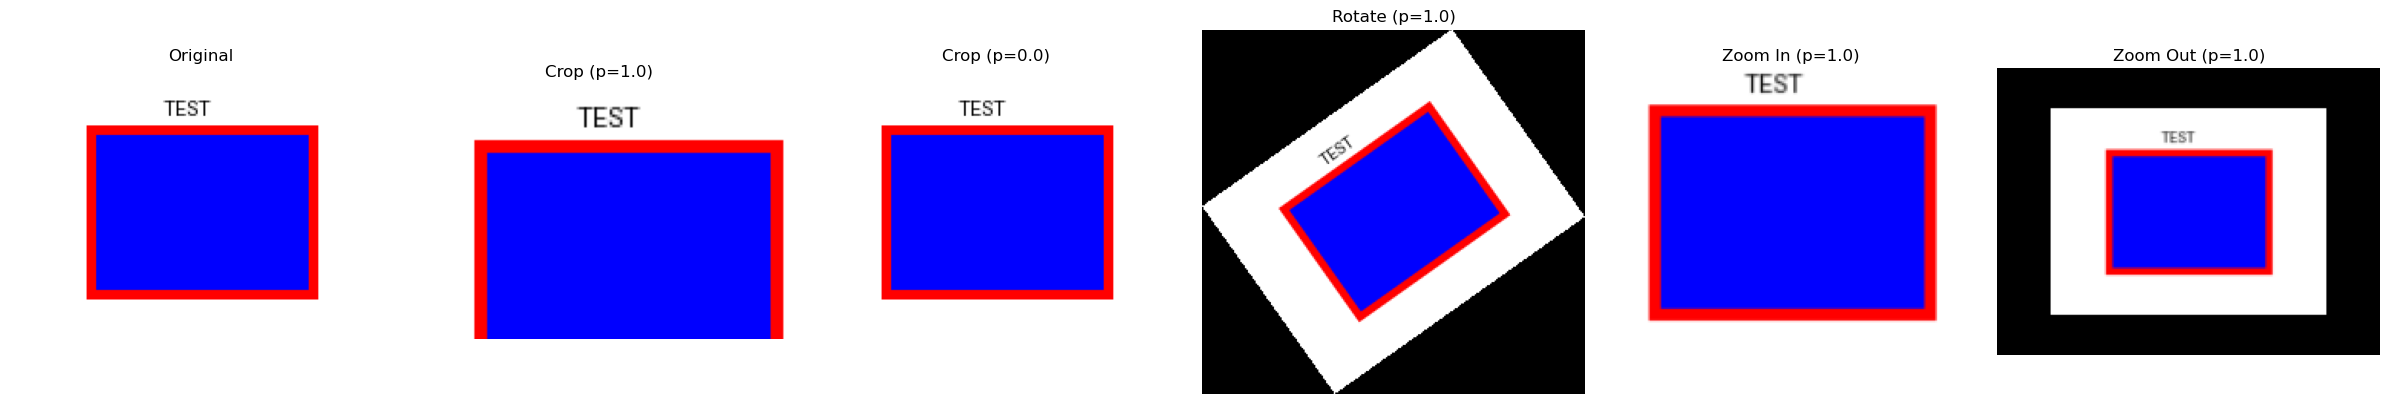


--- 3. Тест ToTensor ---
Тип после ToTensor: <class 'torch.Tensor'>
Форма тензора: torch.Size([3, 150, 200])
Тип данных тензора: torch.float32
Минимальное значение в тензоре: 0.00
Максимальное значение в тензоре: 1.00

--- 4. Тест Compose ---
Применение цепочки трансформаций (Rotate -> Crop -> Zoom -> ToTensor)


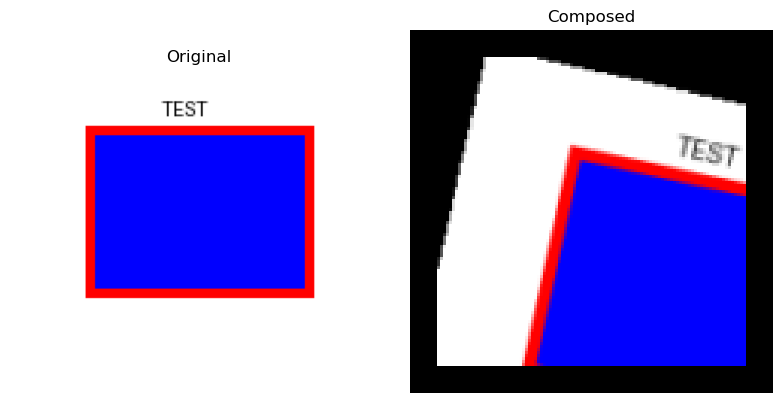

Итоговый тип: <class 'torch.Tensor'>, форма: torch.Size([3, 120, 120])


In [16]:
def create_test_image(w=200, h=150):
    img = Image.new('RGB', (w, h), color='white')
    draw = ImageDraw.Draw(img)
    draw.rectangle(((w*0.2, h*0.2), (w*0.8, h*0.8)), fill='blue', outline='red', width=5)
    draw.text((w*0.4, h*0.1), "TEST", fill='black')
    return img

def plot_transforms(original_img, transforms_dict):
    num_plots = len(transforms_dict) + 1
    fig, axes = plt.subplots(1, num_plots, figsize=(4 * num_plots, 4))
    
    axes[0].imshow(original_img)
    axes[0].set_title("Original")
    axes[0].axis('off')
    
    i = 1
    for name, transformed_img in transforms_dict.items():
        if isinstance(transformed_img, torch.Tensor):
            transformed_img = transformed_img.permute(1, 2, 0)
        axes[i].imshow(transformed_img)
        axes[i].set_title(name)
        axes[i].axis('off')
        i += 1
    plt.tight_layout()
    plt.show()

# 1. Создание исходного изображения
original_image = create_test_image()

# 2. Тестирование воспроизводимости
print("--- 1. Тест на воспроизводимость ---")
random.seed(42)
crop_reproducible = RandomCrop(p=1.0, height=100, width=150)
img1 = crop_reproducible(original_image)
random.seed(42)
img2 = crop_reproducible(original_image)
print(f"Изображения после кропа с одинаковым seed'ом идентичны: {np.array_equal(np.array(img1), np.array(img2))}")

# 3. Тестирование результатов и граничных случаев
print("\n--- 2. Тест результатов и граничных случаев ---")
crop_p1 = RandomCrop(p=1.0, height=100, width=150)
crop_p0 = RandomCrop(p=0.0, height=100, width=150)
rotate_p1 = RandomRotate(p=1.0, degrees=45)
zoom_in_p1 = RandomZoom(p=1.0, zoom_range=(1.2, 1.3))
zoom_out_p1 = RandomZoom(p=1.0, zoom_range=(0.7, 0.8))

transforms_to_show = {
    "Crop (p=1.0)": crop_p1(original_image),
    "Crop (p=0.0)": crop_p0(original_image),
    "Rotate (p=1.0)": rotate_p1(original_image),
    "Zoom In (p=1.0)": zoom_in_p1(original_image),
    "Zoom Out (p=1.0)": zoom_out_p1(original_image),
}
plot_transforms(original_image, transforms_to_show)

# 4. Тестирование ToTensor
print("\n--- 3. Тест ToTensor ---")
to_tensor_transform = ToTensor()
tensor_image = to_tensor_transform(original_image)
print(f"Тип после ToTensor: {type(tensor_image)}")
print(f"Форма тензора: {tensor_image.shape}")
print(f"Тип данных тензора: {tensor_image.dtype}")
print(f"Минимальное значение в тензоре: {tensor_image.min():.2f}")
print(f"Максимальное значение в тензоре: {tensor_image.max():.2f}")

# 5. Тестирование Compose
print("\n--- 4. Тест Compose ---")
composed_transforms = Compose([
    RandomRotate(p=1.0, degrees=15),
    RandomCrop(p=1.0, height=120, width=120),
    RandomZoom(p=1.0, zoom_range=(0.8, 0.9)),
    ToTensor()
])

random.seed(123)
final_image = composed_transforms(original_image)
print("Применение цепочки трансформаций (Rotate -> Crop -> Zoom -> ToTensor)")
plot_transforms(original_image, {"Composed": final_image})
print(f"Итоговый тип: {type(final_image)}, форма: {final_image.shape}")